In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.metrics import Precision, Accuracy
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import schedules
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.16.1
Num GPUs Available:  0


In [ ]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('2_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./data/2_150x9/')

file.close()

In [3]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './data/2_150x9/2_150x9f.csv'
    file_labels = './data/2_150x9/2_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,6))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    # X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    # Y_mod = Y[1000:11000]
    X_mod = X[:,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[:]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Train Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [5]:
# Data gen
timeStep = 10
features = 0

x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

Train shape: (29835, 10, 4)
Timesteps: 10
Train Samples: 29835
Test Samples: 5265
Num features: 4


In [99]:
# fit lstm model
from tabnanny import verbose

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


def fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, time, denseType, dropout, modelVar, learning_rate):
    LstmLayer = LSTM(
    units=neurons,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True, # true if cuDNN
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=dropout, # !important parameter for optimization => 0 if cuDNN
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False, # false if cuDNN
    input_shape=(x_train.shape[1],x_train.shape[2]),
    # input_dim=(x_train.shape[1])
    ) 

    if modelVar == 0:
        model = Sequential() # initializing model
        # input layer and LSTM layer with 50 neurons
        model.add(LstmLayer)
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(20, activation='relu'))
        # outpute layer with sigmoid activation
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        
    if modelVar == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=25))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=75))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 3:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=150))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 4:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=1000, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=1000, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=500))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
    
    # Callback Checkpoint
    checkpoint = ModelCheckpoint(
            filepath='./saved_models/last_saved_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
            )

    # Callback EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=5,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=3)
    
    #  Callback profit
    profitList = list()
    
    class MyCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            predict = model.predict(x_test, batch_size=batch_size)
            profit = funcProfit(predict, Y_test)
            
            if len(profitListSaveModel) == 0:
                model.save(f'./saved_models/best_model_{str(testingParameter)}_{str(time)}.keras')
                print(f"New best model saved, previous best profit -> First")
            elif profit > max(profitListSaveModel):
                model.save(f'./saved_models/best_model_{str(testingParameter)}_{str(time)}.keras')
                print(f"New best model saved, previous best profit -> {str(max(profitListSaveModel))}")
            
            profitList.append(profit)
            profitListSaveModel.append(profit)
            print(f"Profit: {profit}")


    # Optimizer
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    lr_schedule = schedules.InverseTimeDecay(
    # lr_schedule = schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        # return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['precision'])

    # Save initial weights on first compile. In next compile restore initial weights
    if i == 0:
        model.save_weights("./saved_models/initial.weights.h5")
    elif i > 0:
        shuffle_weights(model, weights=None)
        
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=[checkpoint, earlyStopping, MyCallback()], verbose=2) # type: ignore
    
    # Convert list() to array
    profitArray = np.array(profitList)
    
    return model, history, profitArray

In [100]:
# Profit old
def funcProfitOld(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price', 'Open', 'High', 'Low'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Sell'] - df.at[i-1,'Sell']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum


# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.56, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 1000 # 0.20
    sum = 0
    sell = 0
    buy = 0
    for i in range(0, len(df)):
        if (i-1) >= 0:
            if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
                if buy > 0:
                    sell = df.at[i,'Open'] - spread
                    sum += df.at[i,'Open'] - buy
                    buy = 0
                elif sell == 0:
                    sell = df.at[i,'Open'] - spread
            elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
                if df.at[i-1,'High'] >= (sell + tp):
                    sum -= tp
                    sell = 0
                if df.at[i-1,'Low'] <= (sell - tp):
                    sum += tp
                    sell = 0
# --------------------------------------------------------------------------------------------------------

            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
                if sell > 0:
                    buy = df.at[i,'Open'] + spread
                    sum += sell - df.at[i,'Open']
                    sell = 0
                elif buy == 0:
                    buy = df.at[i,'Open'] + spread
            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
                if df.at[i-1,'Low'] <= (buy - tp):
                    sum -= tp
                    buy = 0
                if df.at[i-1,'High'] >= (buy + tp):
                    sum += tp
                    buy = 0

    return round(sum, 2)

In [101]:
# Experiment
def experiment(i, repeats, epochs, neurons, time, denseType, dropout, modelVar, features, learning_rate):
    # # Data gen
    # x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    profitOld = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history, profitArray = fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, epochs, neurons, time, denseType, dropout, modelVar, learning_rate)
        i += 1
        
        # forecast the entire training dataset to build up state for forecasting
        model = load_model(filepath="./saved_models/last_saved_model.keras")
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        # Add column Profit with profit result for epochs
        metric = metric.assign(Profit=profitArray)

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
        profitOld.append(funcProfitOld(predict, Y_test))
    
    return accuracy, profit, profitOld, metrics

In [102]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Accuracy', 'Loss', 'Profit'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1600,
        height=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['Profit'], name=f'profit{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=3)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")
    fig.show()

In [103]:
# Run
from numpy import dtype

repeats = 2
testingParameter = "Timestep"
runMeter = 0
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
results_profitOld = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = 0.001
model = 2 # [0, 1, 2, 3, 4]
dropout = 0 # [0, 0.2, 0.4, 0.6, 0.8]
denseType = 0
neuronsLstm = 150
epochs = 3

timeStep = [10, 20, 50, 100, 150] # 150
features = 0

# # Data gen
# x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

# for dr in dropout:
for tim in timeStep:
    print(f"{tim} {testingParameter} test start...")
 
    x_train, x_test, y_train, y_test, Y_test = data(tim, features)

    #  Profit list
    profitListSaveModel = list()

    # Experiment
    results_acc[str(tim)], results_profit[str(tim)], results_profitOld[str(tim)], metrics = experiment(
                                                                                            runMeter, 
                                                                                            repeats, 
                                                                                            epochs, 
                                                                                            neuronsLstm, 
                                                                                            tim, 
                                                                                            denseType, 
                                                                                            dropout, 
                                                                                            model, 
                                                                                            features, 
                                                                                            learning_rate
                                                                                            )
    # runMeter commented if next loop parameter has different model weights  
    #  runMeter += 1

    plotsOut(tim, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())
print(results_profitOld.describe())

0 Model test start...
Repeat 0 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3

Epoch 1: val_loss improved from inf to 0.61585, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step
Profit: 4.42
133/133 - 74s - 553ms/step - accuracy: 0.6233 - loss: 0.6523 - val_accuracy: 0.6807 - val_loss: 0.6158
Epoch 2/3

Epoch 2: val_loss improved from 0.61585 to 0.59694, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
Profit: 4.18
133/133 - 56s - 421ms/step - accuracy: 0.6578 - loss: 0.6259 - val_accuracy: 0.6840 - val_loss: 0.5969
Epoch 3/3

Epoch 3: val_loss improved from 0.59694 to 0.58739, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step
Profit: 1.1
133/133 - 91s - 683ms/step - accuracy: 0.6648 - loss: 0.6169 - val_accuracy: 0.6947 - val_loss: 0.5874
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step
Repeat 1 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,302 (364.46 KB)

 Trainable params: 93,302 (364.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3

Epoch 1: val_loss improved from inf to 0.60979, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step
Profit: 2.73
133/133 - 63s - 477ms/step - accuracy: 0.6247 - loss: 0.6531 - val_accuracy: 0.6887 - val_loss: 0.6098
Epoch 2/3

Epoch 2: val_loss improved from 0.60979 to 0.59118, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step
New best model saved, previous best profit -> 0
Profit: 3.66
133/133 - 70s - 527ms/step - accuracy: 0.6687 - loss: 0.6156 - val_accuracy: 0.6973 - val_loss: 0.5912
Epoch 3/3

Epoch 3: val_loss improved from 0.59118 to 0.58109, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step
Profit: 2.15
133/133 - 75s - 567ms/step - accuracy: 0.6781 - loss: 0.6062 - val_accuracy: 0.7040 - val_loss: 0.5811
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step


1 Model test start...
Repeat 0 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                  │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3

Epoch 1: val_loss improved from inf to 0.65599, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
Profit: -0.5
133/133 - 63s - 475ms/step - accuracy: 0.5995 - loss: 0.6657 - val_accuracy: 0.6193 - val_loss: 0.6560
Epoch 2/3

Epoch 2: val_loss improved from 0.65599 to 0.61749, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step
New best model saved, previous best profit -> 0
Profit: 3.76
133/133 - 38s - 285ms/step - accuracy: 0.6334 - loss: 0.6414 - val_accuracy: 0.6727 - val_loss: 0.6175
Epoch 3/3

Epoch 3: val_loss improved from 0.61749 to 0.60851, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step
Profit: 2.76
133/133 - 41s - 307ms/step - accuracy: 0.6498 - loss: 0.6310 - val_accuracy: 0.6820 - val_loss: 0.6085
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step
Repeat 1 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                  │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3

Epoch 1: val_loss improved from inf to 0.62443, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step
Profit: -1.86
133/133 - 56s - 421ms/step - accuracy: 0.5978 - loss: 0.6695 - val_accuracy: 0.6720 - val_loss: 0.6244
Epoch 2/3

Epoch 2: val_loss improved from 0.62443 to 0.60189, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step
New best model saved, previous best profit -> 0
Profit: 3.22
133/133 - 41s - 311ms/step - accuracy: 0.6573 - loss: 0.6278 - val_accuracy: 0.6860 - val_loss: 0.6019
Epoch 3/3

Epoch 3: val_loss improved from 0.60189 to 0.59265, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step
Profit: 3.06
133/133 - 37s - 280ms/step - accuracy: 0.6675 - loss: 0.6165 - val_accuracy: 0.6907 - val_loss: 0.5926
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step


2 Model test start...
Repeat 0 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_59 (LSTM)                  │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3

Epoch 1: val_loss improved from inf to 0.63256, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 557ms/step
Profit: 1.19
133/133 - 189s - 1s/step - accuracy: 0.6136 - loss: 0.6620 - val_accuracy: 0.6733 - val_loss: 0.6326
Epoch 2/3

Epoch 2: val_loss improved from 0.63256 to 0.60278, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step
New best model saved, previous best profit -> 0
Profit: 3.92
133/133 - 132s - 991ms/step - accuracy: 0.6545 - loss: 0.6294 - val_accuracy: 0.6860 - val_loss: 0.6028
Epoch 3/3

Epoch 3: val_loss improved from 0.60278 to 0.58555, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step
Profit: 3.09
133/133 - 168s - 1s/step - accuracy: 0.6668 - loss: 0.6154 - val_accuracy: 0.6947 - val_loss: 0.5855
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step
Repeat 1 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_62 (LSTM)                  │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


KeyboardInterrupt: 

In [ ]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

               0        0.2        0.4        0.6       0.8
count   1.000000   1.000000   1.000000   1.000000   1.00000
mean   68.203074  69.071478  68.315506  66.666669  67.60841
std          NaN        NaN        NaN        NaN       NaN
min    68.203074  69.071478  68.315506  66.666669  67.60841
25%    68.203074  69.071478  68.315506  66.666669  67.60841
50%    68.203074  69.071478  68.315506  66.666669  67.60841
75%    68.203074  69.071478  68.315506  66.666669  67.60841
max    68.203074  69.071478  68.315506  66.666669  67.60841
          0   0.2   0.4   0.6   0.8
count  1.00  1.00  1.00  1.00  1.00
mean   5.92  5.36  2.25  0.68  0.37
std     NaN   NaN   NaN   NaN   NaN
min    5.92  5.36  2.25  0.68  0.37
25%    5.92  5.36  2.25  0.68  0.37
50%    5.92  5.36  2.25  0.68  0.37
75%    5.92  5.36  2.25  0.68  0.37
max    5.92  5.36  2.25  0.68  0.37


               0        0.2        0.4        0.6       0.8
count   1.000000   1.000000   1.000000   1.000000   1.00000
mean   68.203074  69.071478  68.315506  66.666669  67.60841
std          NaN        NaN        NaN        NaN       NaN
min    68.203074  69.071478  68.315506  66.666669  67.60841
25%    68.203074  69.071478  68.315506  66.666669  67.60841
50%    68.203074  69.071478  68.315506  66.666669  67.60841
75%    68.203074  69.071478  68.315506  66.666669  67.60841
max    68.203074  69.071478  68.315506  66.666669  67.60841


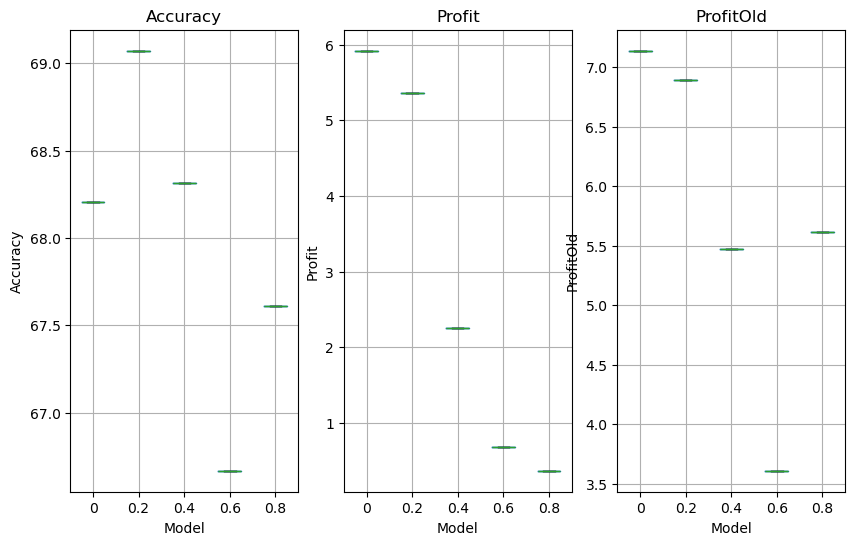

In [ ]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_{testingParameter}.png')
plt.show()

In [8]:
batch_size = 64
model = load_model('./results/18/saved_models/best_model_Timestep_10.keras')
predict = model.predict(x_test, batch_size=batch_size)

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


In [79]:
# Graph green/red
def graphGreenRed(Y_test, batch_size):
    
    # model = load_model('./results/19/saved_models/best_model_Timestep_10.keras')
    # predict = model.predict(x_test, batch_size=batch_size)
    predict_classes = np.where(predict > 0.65, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])
    
    # Tworzenie wykresu liniowego
    fig = go.Figure()

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1400,
        height=1000
    )
    
    start = 1000
    end = start + 1200
    
    # Dodawanie linii do wykresu
    for i in range(start, len(df[:end])):

        color = 'gray'
        if df.at[i-1, 'Buy'] == 1:
            color = 'green'
        elif df.at[i-1, 'Sell'] == 1:
            color = 'red'

        fig.add_trace(go.Scatter(x=[i-1, i], y=[df.at[i-1, 'Open'], df.at[i, 'Open']], line=dict(color=color), showlegend=False))
    
    # Ustawienia osi i tytuł
    fig.update_layout(
        xaxis_title='Indeks',
        yaxis_title='Close',
        title='Wykres liniowy z kolorami'
    )
    
    # Wyświetlanie wykresu
    fig.show()
    
graphGreenRed(Y_test, 64)

In [33]:
print(Y_test[3619:3625])
model = load_model('./results/19/saved_models/best_model_Timestep_10.keras')
predict = model.predict(x_test, batch_size=64)
predict_classes = np.where(predict > 0.55, 1,0)
concat = np.hstack((predict_classes, Y_test[:,2:]))
# df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])
print(df.loc[3619:3665])

[[ 1.    0.   82.79 82.93 82.94 82.77]
 [ 1.    0.   82.78 82.79 82.8  82.74]
 [ 1.    0.   82.84 82.77 82.89 82.76]
 [ 1.    0.   82.9  82.83 82.94 82.83]
 [ 1.    0.   82.9  82.89 82.92 82.87]
 [ 1.    0.   82.92 82.89 82.94 82.86]]
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
      Sell  Buy  Close   Open   High    Low
3619   0.0  1.0  82.79  82.93  82.94  82.77
3620   1.0  0.0  82.78  82.79  82.80  82.74
3621   1.0  0.0  82.84  82.77  82.89  82.76
3622   0.0  0.0  82.90  82.83  82.94  82.83
3623   0.0  1.0  82.90  82.89  82.92  82.87
3624   0.0  1.0  82.92  82.89  82.94  82.86
3625   0.0  1.0  82.81  82.91  82.93  82.79
3626   1.0  0.0  82.80  82.81  82.83  82.79
3627   1.0  0.0  82.90  82.79  82.92  82.79
3628   0.0  1.0  82.78  82.88  82.90  82.78
3629   1.0  0.0  82.84  82.77  82.86  82.77
3630   0.0  0.0  82.73  82.85  82.86  82.58
3631   1.0  0.0  82.64  82.70  82.72  82.63
3632   1.0  0.0  82.67  82.63  82.67  82.62
3633   1.0  0.0  82.73  82.68  82.79  82.67
3634   0.0  0.0  82.7

In [77]:
# Profit
def funcProfitTP(Y_test, tp, batch_size):
    # model = load_model('./results/19/saved_models/best_model_Timestep_10.keras')
    # predict = model.predict(x_test, batch_size=batch_size)
    predict_classes = np.where(predict > 0.90, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])
    # df = df.iloc[3620:3625]

    # Absolute difference prices
    spread = 0.03
    # tp = 1000 # 0.20
    sl = 2
    sum = 0
    sell = 0
    buy = 0
    transact = 0

    # for i in range(3619, 4765):
    for i in range(0, len(df)):
        # print(df.at[i, 'Buy'])

        if (i-3) >= 0:
            buyCondition = 0
            sellCondition = 0
            # Buy condition
            if df.at[i,'Buy'] == 1 and df.at[i-1,'Buy'] == 1 and buy == 0: 
            # if df.at[i,'Buy'] == 1 and df.at[i-1,'Buy'] == 1 and df.at[i-2,'Buy'] == 1 and df.at[i-3,'Buy'] == 0 and buy == 0: 
                buyCondition = 1
            # Sell condition
            if df.at[i,'Sell'] == 1 and df.at[i-1,'Sell'] == 1 and sell == 0: 
                sellCondition = 1

            if df.at[i,'Buy'] == 0:                              # B 0 
                if df.at[i-1,'Buy'] == 0:                        # B-1 0
                    buy = 0
                elif df.at[i-1,'Buy'] == 1 and buy > 0:         # B-1 1
                    sum += df.at[i,'Open'] - buy
                    buy = 0 
            elif buyCondition == 1:                               # B 1
                buy = df.at[i,'Open'] + spread
                transact += 1
                            
            if df.at[i,'Sell'] == 0:                              # S 0
                if df.at[i-1,'Sell'] == 0:                         # S-1 0
                    sell = 0
                elif df.at[i-1,'Sell'] == 1 and sell > 0:        # S-1 1
                    sum += sell - df.at[i,'Open'] - spread
                    sell = 0
            elif sellCondition == 1:                           # S 1
                sell = df.at[i,'Open']
                transact += 1
        
        # TP block
        if buy > 0:
            if df.at[i,'High'] >=(buy + tp):
                sum += tp
                buy = 0  
        elif sell > 0:
            if df.at[i,'Low'] <= (sell - tp):
                sum += tp
                sell = 0
#     for i in range(0, len(df)):
#         if (i-1) >= 0:
#             if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
#                 if buy > 0:
#                     sell = df.at[i,'Open'] - spread
#                     sum += df.at[i,'Open'] - buy
#                     buy = 0
#                 elif sell == 0:
#                     sell = df.at[i,'Open'] - spread
#             elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
#                 if df.at[i-1,'High'] >= (sell + sl):
#                     sum -= sl
#                     sell = 0
#                 if df.at[i-1,'Low'] <= (sell - tp):
#                     sum += tp
#                     sell = 0
# # --------------------------------------------------------------------------------------------------------

#             elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
#                 if sell > 0:
#                     buy = df.at[i,'Open'] + spread
#                     sum += sell - df.at[i,'Open']
#                     sell = 0
#                 elif buy == 0:
#                     buy = df.at[i,'Open'] + spread
#             elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
#                 if df.at[i-1,'Low'] <= (buy - sl):
#                     sum -= sl
#                     buy = 0
#                 if df.at[i-1,'High'] >= (buy + tp):
#                     sum += tp
#                     buy = 0
    return round(sum, 2), transact

for i in range(0, 200, 5):
    print(f"i = {i/100}: {funcProfitTP(Y_test, i/100, 64)}")

i = 0.0: (-4.47, 143)
i = 0.05: (-3.45, 123)
i = 0.1: (-3.37, 110)
i = 0.15: (-3.72, 106)
i = 0.2: (-3.45, 102)
i = 0.25: (-3.5, 100)
i = 0.3: (-3.72, 99)
i = 0.35: (-3.67, 99)
i = 0.4: (-3.6, 98)
i = 0.45: (-3.55, 98)
i = 0.5: (-3.5, 98)
i = 0.55: (-3.45, 98)
i = 0.6: (-3.62, 98)
i = 0.65: (-3.62, 98)
i = 0.7: (-3.62, 98)
i = 0.75: (-3.62, 98)
i = 0.8: (-3.62, 98)
i = 0.85: (-3.62, 98)
i = 0.9: (-3.62, 98)
i = 0.95: (-3.62, 98)
i = 1.0: (-3.62, 98)
i = 1.05: (-3.62, 98)
i = 1.1: (-3.62, 98)
i = 1.15: (-3.62, 98)
i = 1.2: (-3.62, 98)
i = 1.25: (-3.62, 98)
i = 1.3: (-3.62, 98)
i = 1.35: (-3.62, 98)
i = 1.4: (-3.62, 98)
i = 1.45: (-3.62, 98)
i = 1.5: (-3.62, 98)
i = 1.55: (-3.62, 98)
i = 1.6: (-3.62, 98)
i = 1.65: (-3.62, 98)
i = 1.7: (-3.62, 98)
i = 1.75: (-3.62, 98)
i = 1.8: (-3.62, 98)
i = 1.85: (-3.62, 98)
i = 1.9: (-3.62, 98)
i = 1.95: (-3.62, 98)
